In [1]:
import json
import generate_figures as gf

batch_file = '../data/json/cedar_batch_total_dedicated_nt.json'
pilots8_file = '../data/json/cedar_pilots8_total_dedicated_nt.json'
pilots16_file = '../data/json/cedar_pilots16_total_dedicated_nt.json'

gf.batch = gf.load_json(batch_file)
gf.pilots8 = gf.load_json(pilots8_file)
gf.pilots16 = gf.load_json(pilots16_file)

In [2]:
#get makespans
assert(len(gf.batch)==len(gf.pilots8)==len(gf.pilots16))

dedicated_1 = gf.makespan_dict()
dedicated_2 = gf.makespan_dict()
dedicated_3 = gf.makespan_dict()

gf.fill_dictionaries()
        

## FIGURE 0 - RAW

In [3]:
## individual bar charts

def individual_charts(data, n_dedicated):
    n_groups = len(data['batch'])

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.30

    opacity = 0.4

    rects1 = ax.bar(index, data['batch'], bar_width,
                    alpha=opacity, color='r',
                    label='batch')

    rects2 = ax.bar(index + bar_width, data['8pilots'], bar_width,
                    alpha=opacity, color='b',
                    label='8 pilots')

    rects3 = ax.bar(index + 2*bar_width, data['16pilots'], bar_width,
                    alpha=opacity, color='green',
                    label='16 pilots')

    ax.set_xlabel('Iteration #')
    ax.set_ylabel('makespan (s)')
    ax.set_title('Beluga - {} dedicated'.format(n_dedicated))
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels((i + 1 for i in range(n_groups)))
    ax.legend()

    plt.show()

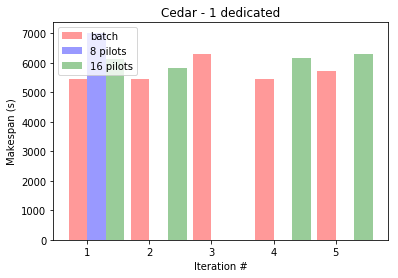

In [4]:
## 1 dedicated
gf.iteration_fig(gf.dedicated_1, 1, system="Cedar")

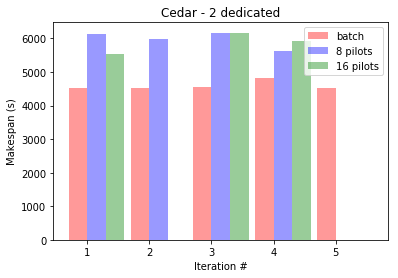

In [5]:
## 2 dedicated
gf.iteration_fig(gf.dedicated_2, 2, system="Cedar")

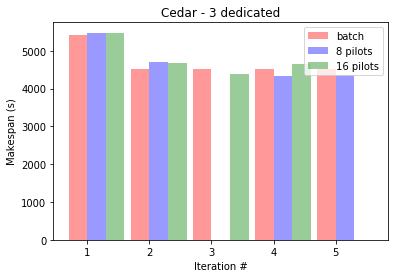

In [6]:
## 3 dedicated
gf.iteration_fig(gf.dedicated_3, 3, system="Cedar")

## FIGURE 1 - Makespan difference

In [7]:
def get_dedicated_data(dedicated_dict, num_pilot):
    batch = dedicated_dict['batch']
    pilot = dedicated_dict['{}pilots'.format(num_pilot)]
    data = [batch[i] - pilot[i] for i in range(len(batch)) if batch[i] != 0 and pilot[i] != 0]
    return data
    
def makespan_box(dedicated_1, dedicate_2, dedicated_3, num_pilot):
    fig, ax = plt.subplots()
    data = [get_dedicated_data(dedicated_1, num_pilot),
            get_dedicated_data(dedicated_2, num_pilot),
            get_dedicated_data(dedicated_3, num_pilot)]
    pos = np.array(range(len(data))) + 1
    bp = ax.boxplot(data, sym='k+', positions=pos)
    
    ax.set_xlabel('# dedicated')
    ax.set_ylabel('makespan')
    ax.set_title('Beluga - {} pilots'.format(num_pilot))
    plt.setp(bp['whiskers'], color='k', linestyle='-')
    plt.setp(bp['fliers'], markersize=3.0)
    plt.show()
    

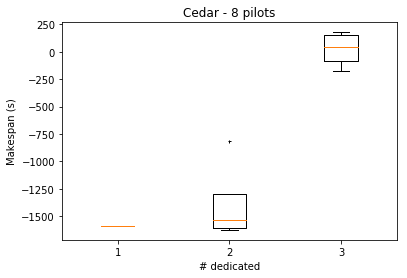

In [8]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, 8, system="Cedar")

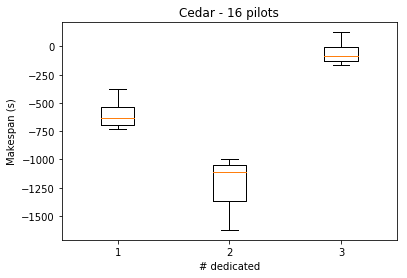

In [9]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, 16, system="Cedar")

## Figure 2 - Queuing time difference

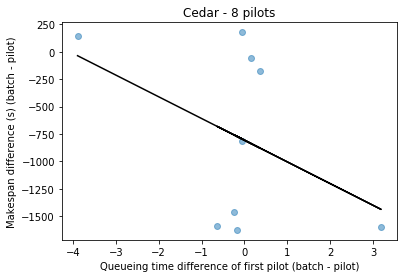

In [10]:
# Beluga 8 pilots
qxlabel = "Queueing time difference of first pilot (batch - pilot)"
qylabel = "Makespan difference (s) (batch - pilot)"

gf.scatter_fig(*gf.makespan_queue(8), num_pilots=8,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")


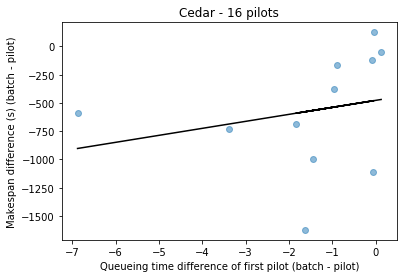

In [11]:
#Beluga 16 pilots
gf.scatter_fig(*gf.makespan_queue(16), num_pilots=16,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")

## Figure 3A - Average number of nodes

In [12]:
from math import floor

def get_pilot_info(job, t):
    if job['end_time'] is None:
        return []
    makespan_dict = {}
    
    makespan_dict[job['start_time']] = []
    makespan_dict[job['end_time']] = []
    # First passage
    for sid in job['sid']:
        if sid['start_time'] not in makespan_dict:
            makespan_dict[sid['start_time']] = [sid[t][0] if t == 'nodes' else sid[t]]
        else:
            makespan_dict[sid['start_time']].extend(sid[t] if t == 'nodes' else [sid[t]])
           
        if sid['end_time'] is None:
            sid['end_time'] = job['end_time']
        if sid['end_time'] not in makespan_dict:
            makespan_dict[sid['end_time']] = [sid[t][0] if t == 'nodes' else sid[t]]
        else:
            makespan_dict[sid['end_time']].extend(sid[t] if t == 'nodes' else [sid[t]])
    # Second passage
    for sid in job['sid']:
        for k,v in makespan_dict.items():
            if k > sid['start_time'] and k < sid['end_time']:
                v.extend(sid['nodes'])
    
    return [(k, len(set(v))) for k, v in sorted(makespan_dict.items())]

pilot_avgtype = lambda x: sum([(x[i][1]*(x[i+1][0] - x[i][0])) 
                                for i in range(1, len(x) - 1)])/(x[-1][0] - x[0][0])
get_pilot_avgnodes = lambda x,y: ((pilot_avgtype(get_pilot_info(x, 'nodes'))),
                                  (y['end_time'] - y['start_time']) - (x['end_time'] - x['start_time']),
                                   x['end_time'] - x['start_time'])


get_batch_avgnodes = lambda x:(((len(set(x['sid'][0]['nodes'])) *
                                  (x['sid'][0]['end_time'] - x['sid'][0]['start_time'])) /
                              (x['end_time'] - x['start_time'])), x['end_time'] - x['start_time'])



In [13]:
avgn_8pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots8)
                if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']]
avgn_16pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                 for idx, job in enumerate(gf.pilots16)
                 if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']]
avgn_batch = [gf.get_batch_avgnodes(job)
              for job in gf.batch 
              if job['success'] and job['end_time'] is not None]

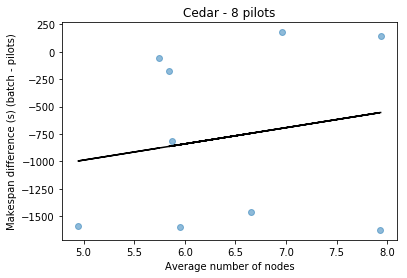

In [14]:
# 8 pilots
as_xlbl = "Average number of {}"
as_ylbl = "Makespan difference (s) (batch - pilots)"
gf.scatter_fig([i[0] for i in avgn_8pilots],
               [i[1] for i in avgn_8pilots], 8,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

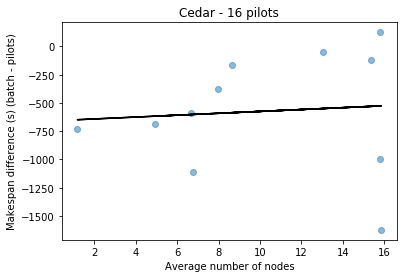

In [15]:
# 16 pilots
gf.scatter_fig([i[0] for i in avgn_16pilots],
               [i[1] for i in avgn_16pilots], 16,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

## Figure 3B - Average number of pilots

In [16]:
avgp_8pilots = [gf.get_avgpilots(job, gf.batch[idx])
               for idx, job in enumerate(gf.pilots8)
               if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']]
avgp_16pilots = [gf.get_avgpilots(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots16)
                if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']]

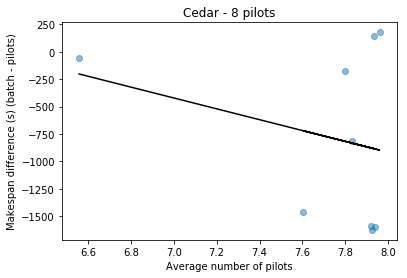

In [17]:
# 8 pilots
gf.scatter_fig([i[0] for i in avgp_8pilots],
               [i[1] for i in avgp_8pilots], 8,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

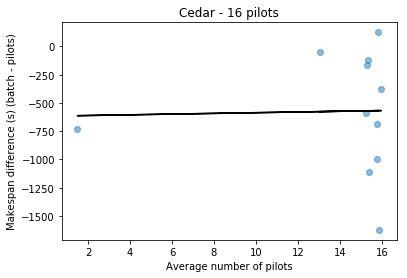

In [18]:
gf.scatter_fig([i[0] for i in avgp_16pilots],
               [i[1] for i in avgp_16pilots], 16,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

In [19]:
batch_pilots8 = [el for el in list(zip(gf.batch, gf.pilots8))
                 if el[0]['success'] and el[1]['success']]

m1_m2_b8 = [(el[0]['end_time'] - el[0]['start_time'])
            / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots8]

batch_aworkers = [(gf.get_batch_avgpilots(el[0])[0]
                    * gf.get_ncpus(el[0]['name']))
                     for el in batch_pilots8]
pilots8_aworkers = [(gf.get_pilot_avgpilots(el[1], el[0])[0]
                     * gf.get_ncpus(el[1]['name']))
                      for el in batch_pilots8]

w2_w1_b8 = [el[1] / el[0] for el in zip(batch_aworkers,
                                        pilots8_aworkers)]


In [20]:

batch_pilots16 = list(zip(gf.batch, gf.pilots16))
m1_m2_b16 = [(el[0]['end_time'] - el[0]['start_time'])
             / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots16
             if el[0]['success'] and el[1]['success']]

w2_w1_b16 = [(gf.get_pilot_avgpilots(el[1], el[0])[0]
              * gf.get_ncpus(el[1]['name'])
             / (gf.get_batch_avgpilots(el[0])[0]
              * gf.get_ncpus(el[0]['name'])))
            for el in batch_pilots16
            if el[0]['success'] and el[1]['success']]

In [21]:
def basic_model(w1w2, m1m2, num_pilot, system="Beluga"):
    fig, ax = plt.subplots()

    ax.scatter(w1w2, m1m2, alpha=0.5)
    
    b, m = np.polynomial.polynomial.polyfit(w1w2, m1m2, 1)
    ax.plot(np.asarray(w1w2), b + m * np.asarray(w1w2), '-')
    ax.set_xlabel('W2 - pilot / W1 - batch')
    ax.set_ylabel('M1 - batch / M2 - pilot')
    ax.set_title('{0} - {1} pilots'.format(system, num_pilot))
    plt.show()
    
    print('Regression line: {0}x + {1}'.format(m, b))

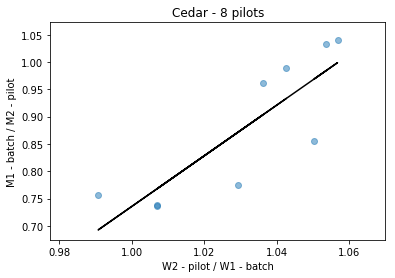

In [22]:
# 8 pilots
bm_x_lbl= "W2 - pilot / W1 - batch"
bm_y_lbl= "M1 - batch / M2 - pilot"
gf.scatter_fig(w2_w1_b8, m1_m2_b8, 8, bm_x_lbl, bm_y_lbl,
               system="Cedar")

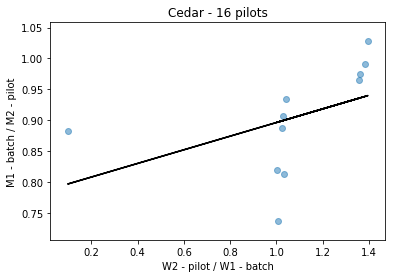

In [23]:
# 16 pilots
gf.scatter_fig(w2_w1_b16, m1_m2_b16, 16, bm_x_lbl, bm_y_lbl,
               system="Cedar")

In [24]:
m_batch = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']]

w_batch = [(gf.get_batch_avgpilots(el)[0]
                * gf.get_ncpus(el['name']))
               for el in gf.batch if el['success']]



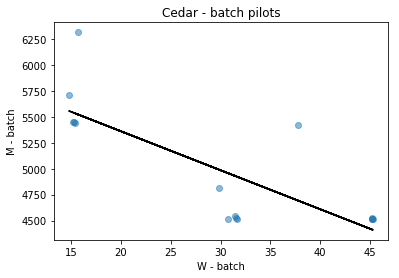

In [25]:
gf.scatter_fig(w_batch, m_batch, "batch",
               "W - batch", "M - batch",
               system="Cedar")

In [26]:
m_8p = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']]

w_8p = [(gf.get_pilot_avgpilots(el, el)[0]
         * gf.get_ncpus(el['name']))
            for el in gf.pilots8 if el['success']]


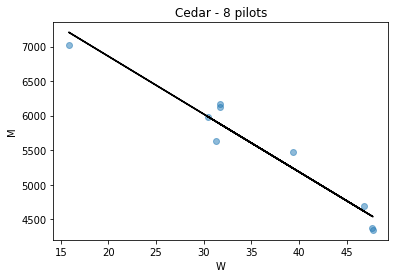

In [27]:
gf.scatter_fig(w_8p, m_8p, 8,
               "W", "M",
               system="Cedar")

In [28]:
m_16p = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']]
w_16p = [(gf.get_pilot_avgpilots(el, el)[0]
          * gf.get_ncpus(el['name']))
            for el in gf.pilots16 if el['success']]


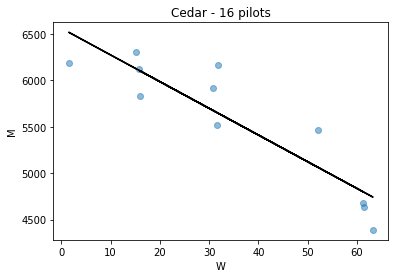

In [29]:
gf.scatter_fig(w_16p, m_16p, 16,
               "W", "M",
               system="Cedar")